In [1]:
# MagnaTagATune Dataset:
# https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset
# Citation: Edith Law, Kris West, Michael Mandel, Mert Bay and J. Stephen Downie (2009). Evaluation of algorithms using games: the case of music annotation. In  Proceedings of the 10th International Conference on Music Information Retrieval (ISMIR)

# GTZAN Dataset:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

#https://musicinformationretrieval.com/spectral_features.html

#https://ofai.at/papers/oefai-tr-2006-13.pdf
#tonnetz



# These are default standard-library things, so we don't have to install them.
import sys
import os
import glob
import random

import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas
import sklearn.datasets
import sklearn.decomposition
import sklearn.model_selection
import k_means_constrained

if not os.path.isdir("Datasets"):
  raise IOError("No Datasets folder exists. This probably means the datasets are not downloaded. Please refer to the readme.")

print(f"Working directory: {os.getcwd()}")

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.set_default_device(device)
  print("Torch is using CUDA.")
else:
  print("Torch is using the CPU.")

Working directory: C:\MusicClassifier
Torch is using CUDA.


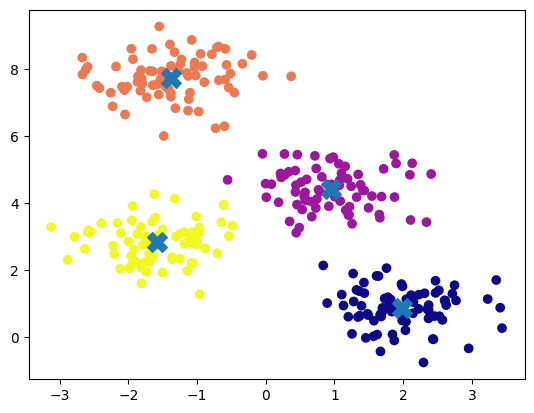

In [2]:
# ##### K-Means ######

# Here's our implementation.
# It's pretty basic, and doesn't do anything to optimize output results for size.
# As such, the clusters usually end up with weird shapes.
# The k_means_constrained algorithm does a better job.

# 
# # Implementation taken from here.
# # https://www.geeksforgeeks.org/pytorch-for-unsupervised-clustering/
# 
# 
# # data: A [data_count * feature_count] torch tensor.
# # returns a tuple (centroids, labels).
# #   centroids: [centroid_count, feature_count] torch tensor
# #   labels: [data_count] torch tensor. Contains the index of each centroid that the given data uses.
# def k_means_cluster(data, centroid_count, iteration_count):
#   feature_count = data.size(dim=1)
# 
#   # TODO: Figure out a better way to initialize the centroids
#   # centroids = torch.rand((centroid_count, feature_count))
#   centroids = data[torch.randperm(data.size(0))[:4]]
# 
#   labels = None
#   for iteration_index in range(iteration_count):
#     distances = torch.cdist(data, centroids)
#     # distances is [data_count, centroid_count]
#     # The distance from each data point to each centroid.
# 
#     # Find the nearest centroid to each data point
#     _, labels = torch.min(distances, dim=1) # labels is a [data_count] tensor
# 
#     for i in range(centroid_count):
#       labels_that_use_this_centroid = labels == i
#       # True for all the indices of data that have this as the nearest centroid, false otherwise
#       if torch.sum(labels_that_use_this_centroid == i) > 0:
# 
#         # This is a goofy overload.
#         # Get all data that has centroid i as the closest centroid.
#         data_that_uses_this_centroid = data[labels_that_use_this_centroid]
# 
#         centroids[i] = torch.mean(data_that_uses_this_centroid, dim=0)
# 
#     if iteration_index == iteration_count - 1:
#       return (centroids, labels)
# 
# 
# # TODO: Make sure this is actually working. The output looks a little weird, but that may have to do with the initial centroid values.
# def test_k_means_cluster():
#   centroid_count = 4
#   data, _ = sklearn.datasets.make_blobs(n_samples=300, centers=centroid_count, cluster_std=0.60, random_state=0)
# 
#   tensor_data = torch.tensor(data, dtype=torch.float32)
#   centroids_gpu, labels_gpu = k_means_cluster(tensor_data, centroid_count, 10000)
# 
#   # We have to transfer it to numpy to be able to use plt on it.
#   centroids = centroids_gpu.cpu().numpy()
#   labels = labels_gpu.cpu().numpy()
# 
#   plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="plasma")
#   plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200)
#   plt.show()
# test_k_means_cluster()

def test_k_means_cluster():
  centroid_count = 4

  data, _ = sklearn.datasets.make_blobs(n_samples=300, centers=centroid_count, cluster_std=0.60, random_state=0)

  clf = k_means_constrained.KMeansConstrained(
      n_clusters=centroid_count,
      size_min=50,
      size_max=100,
      random_state=0
  )
  labels = clf.fit_predict(data)
  centroids = clf.cluster_centers_

  plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="plasma")
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200)
  plt.show()
test_k_means_cluster()

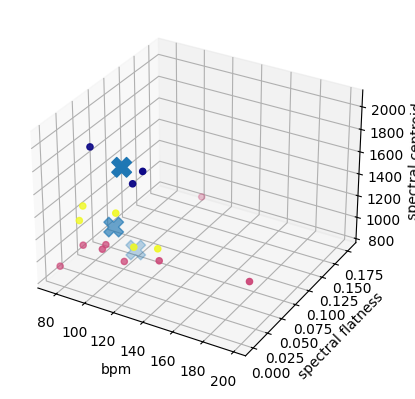

In [3]:
#
# Test clustering based on bpm, spectral flatness, and spectral centroid. #####
#

# Because of dynamic typing, we have to do this.
# Just treat this like a C struct for now.
class MagnaTagATuneSong():
  def __init__(self, name, data, bpm, spectral_flatness, spectral_centroid):
    self.name = name
    self.bpm = bpm
    self.data = data
    self.spectral_flatness = spectral_flatness
    self.spectral_centroid = spectral_centroid

dirs = os.listdir('Datasets/MagnaTagATune')
songs = []
for dir_name in dirs:
  dir = f"Datasets/MagnaTagATune/{dir_name}"
  if not os.path.isdir(dir):
    continue

  song_names = os.listdir(dir)
  for i in range(1): # TODO: Speed this up so we can read in a lot of data at once.

    # Right now, we want reproducability. We'll just use the first song we find.
    # song_name_idx = random.randrange(len(song_names))
    song_name_idx = i

    song_name = song_names[song_name_idx]
    song_path = f"{dir}/{song_name}"
    file_data, file_sample_rate = librosa.load(song_path)
    (bpm_array, _) = librosa.beat.beat_track(y=file_data)

    # Librosa returns an array of bpms, one for each channel of your audio.
    # We should only have a single channel, so assert on that for now.
    assert(isinstance(bpm_array, np.ndarray))
    assert(len(bpm_array) == 1)

    # The spectral flatness is a 2D array.
    # It should have number of Fast Fourier Transform "frames".
    # In this example, there is only one frame.
    # TODO: Understand what a Fast Fourier Transform frame is.
    spectral_flatness = librosa.feature.spectral_flatness(y=file_data)
    assert(len(spectral_flatness) == 1)

    # For some reason, librosa.feature.spectral_centroid returns a 2d array,
    # where the first dimension is always zero.
    spectral_centroid = librosa.feature.spectral_centroid(y=file_data)
    assert(len(spectral_centroid) == 1)

    song = MagnaTagATuneSong(
        name=song_path,
        data=file_data,
        bpm=bpm_array[0],
        spectral_flatness=np.mean(spectral_flatness[0]),
        spectral_centroid=np.mean(spectral_centroid[0]))
    songs.append(song)



def plot_bpm_and_spectral_flatness():

  figure = plt.figure()
  subplot = figure.add_subplot(projection='3d')
  subplot.set_xlabel("bpm")
  subplot.set_ylabel("spectral flatness")
  subplot.set_zlabel("spectral centroid")

  data_py = []
  for song in songs:
    data_py.append([song.bpm, song.spectral_flatness, song.spectral_centroid])

  data = np.array(data_py)

  cluster_count = 3

  cluster_size_avg = len(songs) / float(cluster_count)

 # These are values I chose so the clusters aren't too big or
  cluster_size_min = int(cluster_size_avg * 2/3)
  cluster_size_max = int(cluster_size_avg * 1.5)

  clf = k_means_constrained.KMeansConstrained(
    n_clusters=cluster_count,
    size_min=cluster_size_min,
    size_max=cluster_size_max,
    random_state=0
  )

  labels = clf.fit_predict(data)
  clusters = clf.cluster_centers_

  subplot.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="plasma")
  subplot.scatter(clusters[:, 0], clusters[:, 1], clusters[:, 2], marker="X", s=200)
  plt.show()

plot_bpm_and_spectral_flatness()

In [8]:
# Load GTZAN labels
gtzan_genre_count = 10
gtzan_songs_per_genre = 100


graph_point_size = 10
graph_cluster_label_size = 100

# Test clustering features in respect to genre
frame = pandas.read_csv("Datasets/GTZAN/features_30_sec.csv")

# The first two features are:
# The file name (which we don't need)
# The sample length (which is always the same).
# So we can ignore them.
data = frame.to_numpy()[:, 2:frame.columns.size-1].astype(np.float32)
feature_names = np.array(frame.columns[2:frame.columns.size-1])
genre_names = np.array([frame.at[i * gtzan_songs_per_genre, "label"] for i in range(gtzan_genre_count)])
genre_labels = np.repeat(np.arange(0, gtzan_genre_count), gtzan_songs_per_genre)


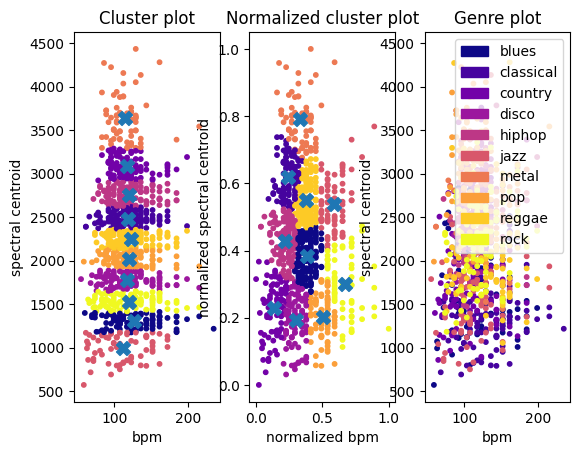

In [9]:
# Test clustering for bpm and spectral centroid

def gtzan_bpm_and_specular_centroid(
    bpm: np.array,
    spectral_centroid: np.array,
    genre_names: np.array,
    genre_labels: np.array,
    cluster_plot: matplotlib.axes.Axes,
    normalized_plot: matplotlib.axes.Axes,
    genre_plot: matplotlib.axes.Axes):

    clf = k_means_constrained.KMeansConstrained(
        n_clusters = gtzan_genre_count,
        size_min = int(gtzan_songs_per_genre * 2/3),
        size_max = int(gtzan_songs_per_genre * 1.5),
        random_state = 0
    )
    
    cluster_data = np.stack((bpm, spectral_centroid), axis=-1)
    cluster_labels = clf.fit_predict(cluster_data)
    
    cluster_plot.set_title("Cluster plot")
    cluster_plot.set_xlabel("bpm")
    cluster_plot.set_ylabel("spectral centroid")
    cluster_plot.scatter(bpm, spectral_centroid, c=cluster_labels, cmap="plasma", s=graph_point_size)
    cluster_plot.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], marker="X", s=graph_cluster_label_size)

    
    # bpm and spectral centroids are in drastically different units.
    # This results in the clustering being very linear, as seen in
    # the non-normalized graph. To fix this, we will normalize the 
    # bpm and spectral centroid to be between 0 and 1, and then cluster.
    #           -berk, November 11, 2024

    def numpy_normalize(array):
        array_min = np.min(array)
        array_max = np.max(array)
        return (array - array_min) / (array_max - array_min)

    normalized_bpm = numpy_normalize(bpm)
    normalized_spectral_centroid = numpy_normalize(spectral_centroid)
    normalized_data = np.stack((normalized_bpm, normalized_spectral_centroid), axis=-1)
    normalized_labels = clf.fit_predict(normalized_data)

    normalized_plot.set_title("Normalized cluster plot")
    normalized_plot.set_xlabel("normalized bpm")
    normalized_plot.set_ylabel("normalized spectral centroid")

    normalized_plot.scatter(normalized_bpm, normalized_spectral_centroid, c=normalized_labels, cmap="plasma", s=graph_point_size)
    normalized_plot.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], marker="X", s=graph_cluster_label_size)

    
    #
    # Now, generate a plot where each point on the (bpm, spectral_centroid) axis is a color that corresponds to its genre.
    #

    # The songs are in order, with the first 100 songs being one genre,
    # the next 100 being another genre, etc. This generates an array
    # that looks like this:
    # [0, 0, 0,... , 0, 1, 1, 1, ...., 1, 2, ...., 2, ...]
    # It has 100 0s followed by  100 2s followed by 100 3s, and so on.
    # These are integer labels by genre.
    #           -berk, November 11, 2024

    genre_plot.set_title("Genre plot")
    genre_plot.set_xlabel("bpm")
    genre_plot.set_ylabel("spectral centroid")
    genre_plot.scatter(bpm, spectral_centroid, c=genre_labels, cmap="plasma", s=graph_point_size)
    colors = plt.colormaps['plasma'](np.linspace(0, 1, gtzan_genre_count))
    patches = [matplotlib.patches.Patch(color=color) for color in colors]
    genre_plot.legend(patches, genre_names)  


_, (cluster_plot, normalized_plot, genre_plot) = plt.subplots(ncols=3)
gtzan_bpm_and_specular_centroid(
    frame["tempo"],
    frame["spectral_centroid_mean"],
    genre_names,
    genre_labels,
    cluster_plot,
    normalized_plot,
    genre_plot)

plt.show()

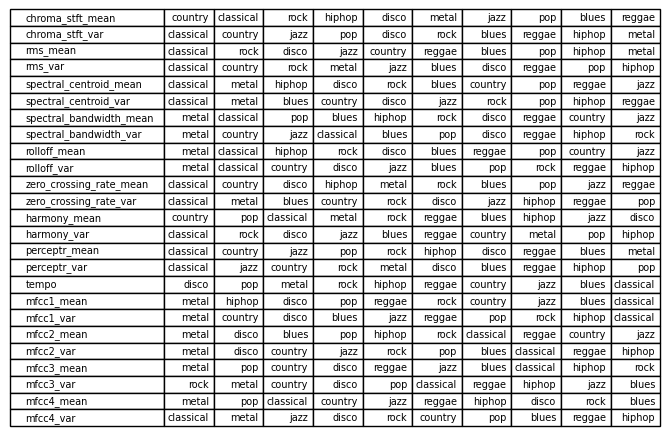

In [14]:
def gtzan_genres_most_associated_with_features(
    data: np.array,
    genre_names: np.array,
    feature_names: np.array,
    plot: matplotlib.axes.Axes):

    # The last 40 features in the input data are 20 pairs of mfcc means and variances.
    # As far as I can tell these become less meaningful the higher your mfcc index is.
    # So we will ignore the last 16, and because there are mean and variance for each one,
    # this becomes 32.
    feature_end_index = data.shape[1] - 32
    data = data[:, :feature_end_index]
    feature_names = feature_names[:feature_end_index]


    feature_count = data.shape[1]
    feature_genre_stdev = np.ndarray((feature_count, gtzan_genre_count), dtype=np.float32)
    # A [gtzan_genre_count, feature_count] array. Contains the standard deviation of each feature per genre.

    # ToDo: Figure out how to vectorize this
    for genre_index in range(gtzan_genre_count):
        start_index = genre_index * gtzan_songs_per_genre
        end_index = start_index + gtzan_songs_per_genre - 1
        for feature_index in range(feature_count):
            genre_feature = data[start_index:end_index, feature_index]
            # All the values of a specific feature per genre
            stdev = np.std(genre_feature)
            feature_genre_stdev[feature_index, genre_index] = stdev

    genres_ranked_per_feature = np.argsort(feature_genre_stdev, axis=1)

    cell_text = genre_names[genres_ranked_per_feature]

    plot.axis("off") 
    plot.table(cellText=cell_text, rowLabels=feature_names, loc="center")


_, plot = plt.subplots()
gtzan_genres_most_associated_with_features(data, genre_names, feature_names, plot)
plt.show()




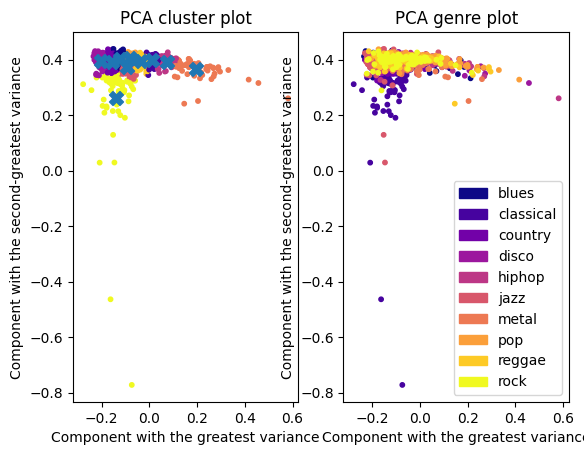

In [15]:
# Now, try to use PCA.

def gtzan_pca(
    data: np.array,
    genre_names: np.array,
    feature_names: np.array,
    genre_labels: np.array,
    cluster_plot: matplotlib.axes.Axes,
    genre_plot: matplotlib.axes.Axes):
    
    pca = sklearn.decomposition.PCA(n_components=2)

    # TODO: Fix having to transpose, then untranspose it!
    pca.fit(data.T)

    clf = k_means_constrained.KMeansConstrained(
        n_clusters = gtzan_genre_count,
        size_min = int(gtzan_songs_per_genre * 2/3),
        size_max = int(gtzan_songs_per_genre * 1.5),
        random_state = 0
    )

    components = pca.components_.T
    labels = clf.fit_predict(components)

    components_x = components[:, 0]
    components_y = components[:, 1]

    cluster_plot.set_title("PCA cluster plot")
    cluster_plot.set_xlabel("Component with the greatest variance")
    cluster_plot.set_ylabel("Component with the second-greatest variance")

    cluster_plot.scatter(components_x, components_y, c=labels, cmap="plasma", s=graph_point_size)
    cluster_plot.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], marker="X", s=graph_cluster_label_size)

    genre_plot.set_title("PCA genre plot")
    genre_plot.set_xlabel("Component with the greatest variance")
    genre_plot.set_ylabel("Component with the second-greatest variance")
    genre_plot.scatter(components_x, components_y, c=genre_labels, cmap="plasma", s=graph_point_size)


def gtzan_torch_pca(
    data: np.array,
    genre_names: np.array,
    feature_names: np.array,
    genre_labels: np.array,
    cluster_plot: matplotlib.axes.Axes,
    genre_plot: matplotlib.axes.Axes):
    
    tensor = torch.Tensor(data)
    tensor = torch.nn.functional.normalize(tensor, dim=1)

    (_, _, principal_components) = torch.pca_lowrank(tensor)
    
    components = torch.matmul(tensor, principal_components[:, :2]).numpy()

    clf = k_means_constrained.KMeansConstrained(
        n_clusters = gtzan_genre_count,
        size_min = int(gtzan_songs_per_genre * 2/3),
        size_max = int(gtzan_songs_per_genre * 1.5),
        random_state = 0
    )

    labels = clf.fit_predict(components)

    components_x = components[:, 0]
    components_y = components[:, 1]

    cluster_plot.set_title("PCA cluster plot")
    cluster_plot.set_xlabel("Component with the greatest variance")
    cluster_plot.set_ylabel("Component with the second-greatest variance")

    cluster_plot.scatter(components_x, components_y, c=labels, cmap="plasma", s=graph_point_size)
    cluster_plot.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], marker="X", s=graph_cluster_label_size)
    genre_plot.set_title("PCA genre plot")
    genre_plot.set_xlabel("Component with the greatest variance")
    genre_plot.set_ylabel("Component with the second-greatest variance")
    genre_plot.scatter(components_x, components_y, c=genre_labels, cmap="plasma", s=graph_point_size)

    colors = plt.colormaps['plasma'](np.linspace(0, 1, gtzan_genre_count))
    patches = [matplotlib.patches.Patch(color=color) for color in colors]
    genre_plot.legend(patches, genre_names)



_, (pca_cluster_plot, pca_genre_plot) = plt.subplots(ncols=2)
gtzan_torch_pca(
  data, 
  genre_names,
  feature_names,
  genre_labels,
  pca_cluster_plot,
  pca_genre_plot)

plt.show()

642185


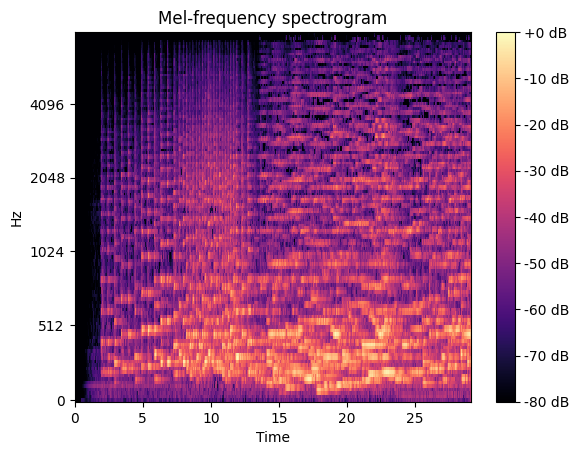

In [16]:
#
# Test generating a mel-frequency spectrogram
#

def plot_spectral_flatness():
  (file_data, file_sample_rate) = librosa.load("Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3")
  print(len(file_data))

  # matplotlib test data
  S = librosa.feature.melspectrogram(y=file_data, sr=file_sample_rate, n_mels=128, fmax=8000)

  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=file_sample_rate, fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')
plot_spectral_flatness()

In [17]:
#
# Testing librosa features
#

(file_data, file_sample_rate) = librosa.load("Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3")
print(len(file_data))
print(file_data)

#beat detection test
bpm = librosa.beat.beat_track(y=file_data, sr=22050, onset_envelope=None, hop_length=512, start_bpm=100.0, tightness=100, trim=True, bpm=None, prior=None, units='frames', sparse=True)
print(bpm)
plp = librosa.beat.plp(y=file_data, sr=22050, onset_envelope=None, hop_length=512, win_length=384, tempo_min=30, tempo_max=300, prior=None)
print(plp)
tempo = librosa.feature.tempo(y=file_data)
print(tempo)

#Spectral Flatness, Noise level test
spect_flat = librosa.feature.spectral_flatness(y=file_data, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', amin=1e-10, power=2.0)
print(spect_flat)
print(np.mean(spect_flat[0]))

#Spectral Centroid, avergae pitch
spect_cent = librosa.feature.spectral_centroid(y=file_data, sr=22050, S=None, n_fft=2048, hop_length=512, freq=None, win_length=None, window='hann', center=True, pad_mode='constant')
print(spect_cent)
print(np.mean(spect_cent[0]))

#tonnetz, chord progression
tonnetz = librosa.feature.tonnetz(y=file_data, sr=22050, chroma=None)
print(tonnetz)

642185
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.1994424e-08
 -1.7516859e-07  0.0000000e+00]
(array([123.046875]), array([ 85, 106, 127, 149, 170, 191, 212, 232, 253, 273, 294, 315, 335,
       355, 375, 395, 413, 432, 451, 472, 493, 512, 530, 549]))
[0.54053307 0.48676527 0.39070755 ... 0.         0.         0.        ]
[123.046875]
[[1.0000007e+00 1.0000007e+00 1.0000007e+00 ... 1.7357328e-05
  7.6356315e-05 7.8214994e-03]]
0.0160148
[[   0.            0.            0.         ... 1230.61303518
  1269.80653303 1966.84925467]]
1188.4008724760527
[[ 0.00670417 -0.01973386 -0.01749379 ... -0.09221619 -0.00731805
  -0.00918203]
 [ 0.04814275  0.02881461  0.03533646 ...  0.0148295  -0.02502549
  -0.02329974]
 [-0.15828665 -0.13938877 -0.10909565 ... -0.07463484 -0.09189442
  -0.06915709]
 [ 0.09349361  0.04074978  0.02197798 ... -0.16149455 -0.04453438
   0.04264478]
 [ 0.04402362  0.04413963  0.0334186  ...  0.08787782  0.04412592
   0.02098133]
 [-0.03318013 -0.03477629 -0.02

In [19]:
#
# Function for extracting desired features from files to be utilized during training; not finished
#

def extract_features(filename):
    # features = []
    audio, sr = librosa.load(filename)

    #mel frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=1)
    #frame length and hop length to be adjusted as necessary, currently using placeholders
    zero_cr = librosa.feature.zero_crossing_rate(audio, frame_length=4, hop_length=1)
    features = [mfcc, zero_cr]

    '''
    potentially change this to instead take the mean, std, max, and min of each feature instead, further research needed
    '''
    return features;

In [20]:
#
# Testing extract_features
#

example_path = 'Datasets/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3'
print(extract_features(example_path))

[array([[-687.12805, -687.12805, -687.12805, ..., -314.5976 , -422.71902,
        -681.53015]], dtype=float32), array([[0.  , 0.  , 0.  , ..., 0.5 , 0.25, 0.25]])]


In [26]:
BASE_DIR = 'Datasets/MagnaTagATune'
sub_dirs = os.listdir(BASE_DIR)
file_paths = []

for folder in sub_dirs:
  if len(folder) == 1:
    folder_path = os.path.join(BASE_DIR, folder)
    for path in os.listdir(folder_path):
      file_paths.append(
          os.path.join(folder_path, path))

# print(file_paths)
# print(len(file_paths))
# example filepath: '/content/gdrive/MyDrive/MusicClassifier/MagnaTagATune/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3'

In [27]:
# Dataset construction
class MusicDataset(Dataset):
  def __init__(self, file_paths, transforms=None):
    self.file_paths = file_paths
    self.transforms = transforms

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, ind):
    audio, sr = librosa.load(self.file_paths[ind])
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    spectrogram = librosa.power_to_db(spectrogram)
    if self.transforms:
      spectrogram = self.transforms(spectrogram)
    return spectrogram

  def visualize(self, ind):
    spectrogram = self.__getitem__(ind)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(spectrogram, ax=ax)
    fig.colorbar(img, ax=ax)


In [29]:
training_data = MusicDataset(file_paths)
# validation size = 0.1
# training_data, val_data = sklearn.model_selection.train_test_split(training_data, test_size=0.1, random_state=42)  
# print("Length of training dataset:",len(training_data))

(128, 1255)


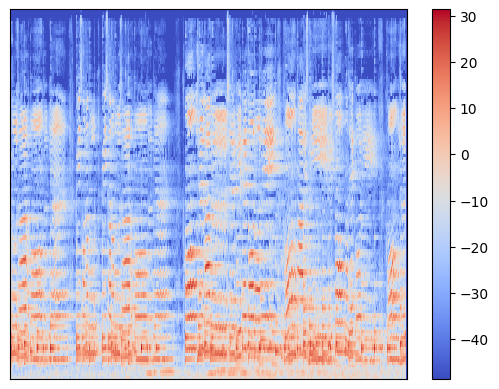

In [30]:
rand = random.randint(0, len(training_data))
training_data.visualize(rand)
print(training_data.__getitem__(rand).shape) # mel_bands, _

In [31]:
trainloader = DataLoader(training_data, batch_size=32, shuffle=True)
print(len(trainloader))

809


In [32]:
# CNN
# class MusicClassifierCNN(nn.Module):
#   def __init__(self):
#     super().__init__()
  
#   def forward(self, x):

model = nn.Sequential()